# COMP4660/8420 Lab 1.2 - Building a Neural Network in PyTorch using built-in packages

During the semester, we will use PyTorch (http://pytorch.org/) as a tool to implement the algorithms we will learn. It is an open source machine learning library for Python.

This notebook will guide you through a quick and easy way to build a neural network using the built in packages provided by PyTorch.
______

## Step 0: Download and import all required libraries

To run this notebook, you need to have the following packages installed:
-  torch: a python deep learning package
-  pandas: a python data analysis package; if you are familiar with numpy, you can use numpy instead
-  matplotlib: a python package for data visualization

To install pytorch, please follow the __[instructions on their website](http://pytorch.org/)__. Please ensure you install version 0.4 or above.

To install pandas, in your terminal, type `pip3 install pandas` for python 3.

To install matplotlib, in your terminal, type `pip install matplotlib` for python 3.

In [1]:
# import libraries
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Step 1: Load and setup training dataset

The dataset is separated into two files from original dataset:
-  iris_train.csv = dataset for training purpose, 80% from the original data
-  iris_test.csv  = dataset for testing purpose, 20% from the original data

In [2]:
# load training data
data_train = pd.read_csv('iris_train.csv')

# convert string target values to numeric values
#       class 0: Iris-setosa
#       class 1: Iris-versicolor
#       class 2: Iris-virginica
data_train.at[data_train['species'] == 'Iris-setosa', ['species']] = 0
data_train.at[data_train['species'] == 'Iris-versicolor', ['species']] = 1
data_train.at[data_train['species'] == 'Iris-virginica', ['species']] = 2

# Also convert all string numeric values to int ['2' -> 2]
data_train = data_train.apply(pd.to_numeric)

Before we start training constructing our neural network, let's look at the dataset and understand it. Complete details can be found __[here](https://archive.ics.uci.edu/ml/datasets/iris)__. We strongly encourage you to open the link. You will find most of your datasets on the linked UCI website for future labs and assignments.

In [3]:
# print data
print(data_train)

     sepal_length  sepal_width  petal_length  petal_width  species
0             5.1          3.4           1.5          0.2        0
1             6.3          2.5           5.0          1.9        2
2             5.9          3.0           4.2          1.5        1
3             5.7          2.6           3.5          1.0        1
4             7.7          2.8           6.7          2.0        2
..            ...          ...           ...          ...      ...
115           5.6          2.5           3.9          1.1        1
116           6.4          2.9           4.3          1.3        1
117           7.9          3.8           6.4          2.0        2
118           5.4          3.0           4.5          1.5        1
119           5.5          3.5           1.3          0.2        0

[120 rows x 5 columns]


_**Q1. How many features (inputs) are there?**_

_**Q2. How many classes (outputs) are there?**_

_**Q3. How many data instances are there?**_

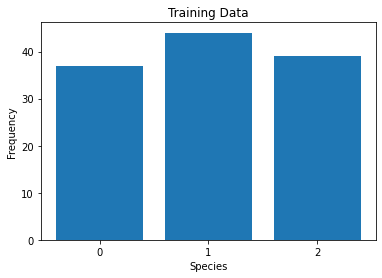

In [4]:
# visualize distribution of data

# extract frequency of each species class
class_freq = data_train['species'].value_counts()
class_freq = list(class_freq.sort_index())

# x-axis labels and length
x_axis = list(range(0,3))

graph = plt.bar(x_axis, class_freq)
plt.xticks(x_axis)
plt.ylabel('Frequency')
plt.xlabel('Species')
plt.title('Training Data')

plt.show()

Looking at the distribution is useful to figure out if the classes are imbalanced or not. In this case, they are fairly well balanced.

In [5]:
# convert pandas dataframe to array
# the first 4 columns are features
# the last column is target
data_train_array = data_train.values

# split x (features) and y (targets)
x_array = data_train_array[:, :4]
y_array = data_train_array[:, 4]

# create Tensors to hold inputs and outputs. Tensors are data structures
# similar to numpy matrices. They can be operated on efficiently by a GPU
# 
# Note: In torch versions before 0.4, Tensors had to be wrapped in a Variable
# to be used by the NN.
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

## Step 2: Define and train a neural network

Here we build a neural network with one hidden layer.
-  input layer: 4 neurons, representing the features of Iris
-  hidden layer: 10 neurons, using Sigmoid as activation function
-  output layer: 3 neurons, representing the classes of Iris
    
The network will be trained with Stochastic Gradient Descent (SGD) as an 
optimiser, that will hold the current state and will update the parameters
based on the computed gradients.

Its performance will be evaluated using cross-entropy.

In PyTorch, the nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Variables and computes output Variables, but may also hold internal state such as Variables containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

We use the nn package to define our model as a sequence of layers.
nn.Sequential is a Module which contains other Modules, and applies them 
in sequence to produce its output. Each Linear Module computes output from 
input using a linear function, and holds internal Variables for its weight 
and bias.


In [15]:
# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
input_neurons = 4
hidden_neurons = 1000
output_neurons = 3
learning_rate = 0.01
num_epoch = 301

In [16]:
# define the structure of our neural network
# each linear layer contains internal variables for weight and bias
net = torch.nn.Sequential(
    torch.nn.Linear(input_neurons, hidden_neurons),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_neurons, output_neurons),
)

# define loss functions
loss_func = torch.nn.CrossEntropyLoss()

# define optimiser
optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [17]:
# store all losses for visualisation
all_losses = []

# train a neural network
for epoch in range(num_epoch):
    # Perform forward pass: compute predicted y by passing x to the model.
    # Here we pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    # In this case, Y_pred contains three columns, where the index of the
    # max column indicates the class of the instance
    Y_pred = net(X)

    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    loss = loss_func(Y_pred, Y)
    all_losses.append(loss.item())

    # print progress
    if epoch % 50 == 0:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(F.softmax(Y_pred,1), 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

    # Clear the gradients before running the backward pass.
    net.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to
    # all the learnable parameters of the model.
    loss.backward()

    # Calling the step function on an Optimiser makes an update to its
    # parameters
    optimiser.step()

Epoch [1/301] Loss: 1.1143  Accuracy: 30.83 %
Epoch [51/301] Loss: 0.6500  Accuracy: 97.50 %
Epoch [101/301] Loss: 0.5353  Accuracy: 97.50 %
Epoch [151/301] Loss: 0.4735  Accuracy: 97.50 %
Epoch [201/301] Loss: 0.4310  Accuracy: 97.50 %
Epoch [251/301] Loss: 0.3982  Accuracy: 98.33 %
Epoch [301/301] Loss: 0.3713  Accuracy: 98.33 %


Plot historical loss from `all_losses` during network learning.

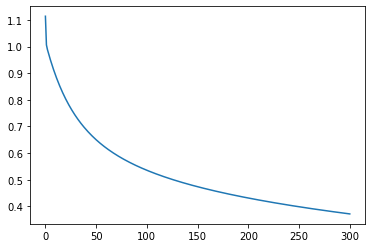

In [18]:
plt.figure()
plt.plot(all_losses)
plt.show()

#### Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every iris flower (rows)
which class the network guesses (columns). 


In [19]:
confusion = torch.zeros(output_neurons, output_neurons)

Y_pred = net(X)
_, predicted = torch.max(F.softmax(Y_pred,1), 1)

for i in range(x_array.shape[0]):
    actual_class = Y.data[i]
    predicted_class = predicted.data[i]

    confusion[actual_class][predicted_class] += 1

print('')
print('Confusion matrix for training:')
print(confusion.numpy())


Confusion matrix for training:
[[37.  0.  0.]
 [ 0. 42.  2.]
 [ 0.  0. 39.]]


_**Q4: What is the training accuracy?**_

_**Q5: What does the confusion matrix tell you?**_

## Step 3: Load and setup testing dataset

The dataset is separated into two files from original dataset:
-  iris_train.csv = dataset for training purpose, 80% from the original data
-  iris_test.csv  = dataset for testing purpose, 20% from the original data

In [20]:
# load testing data
data_test = pd.read_csv('iris_test.csv')

# convert string target values to numeric values
#       class 0: Iris-setosa
#       class 1: Iris-versicolor
#       class 2: Iris-virginica
data_test.at[data_test['species'] == 'Iris-setosa', ['species']] = 0
data_test.at[data_test['species'] == 'Iris-versicolor', ['species']] = 1
data_test.at[data_test['species'] == 'Iris-virginica', ['species']] = 2

# Also convert all string numeric values to int ['2' -> 2]
data_test = data_test.apply(pd.to_numeric)

In [21]:
# convert pandas dataframe to array
# the first 4 columns are features
# the last column is target
data_test_array = data_test.values

# split x (features) and y (targets)
x_test_array = data_test_array[:, :4]
y_test_array = data_test_array[:, 4]

# create Tensors to hold inputs and outputs
X_test = torch.tensor(x_test_array, dtype=torch.float)
Y_test = torch.tensor(y_test_array, dtype=torch.long)

## Step 4: Test the neural network

Pass testing data to the built neural network and get its performance

In [22]:
# test the neural network using testing data
# It is actually performing a forward pass computation of predicted y
# by passing x to the model.
# Here, Y_pred_test contains three columns, where the index of the
# max column indicates the class of the instance
Y_pred_test = net(X_test)

# get prediction
# convert three-column predicted Y values to one column for comparison
_, predicted_test = torch.max(F.softmax(Y_pred_test,1), 1)

# calculate accuracy
total_test = predicted_test.size(0)
correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())

print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))

Testing Accuracy: 100.00 %


#### Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every iris flower (rows)
which class the network guesses (columns). 

In [23]:
confusion_test = torch.zeros(output_neurons, output_neurons)

for i in range(x_test_array.shape[0]):
    actual_class = Y_test.data[i]
    predicted_class = predicted_test.data[i]

    confusion_test[actual_class][predicted_class] += 1

print('')
print('Confusion matrix for testing:')
print(confusion_test.numpy())


Confusion matrix for testing:
[[13.  0.  0.]
 [ 0.  6.  0.]
 [ 0.  0. 11.]]


_**Q6. What is the testing accuracy?**_

_**Q7. How does it compare to the training accuracy?**_

Now adjust the number of hidden neurons to a value of your choice, and record the error and accuracy of the change. Adjust the number of neurons again, making sure that you have tried values both above and below the initial value of 10. (You will need to run all the blocks after the one you make changes in).